In [1]:
epochs = 20

# 공통 설정

In [2]:
!pip install pydicom

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns
import torch.nn as nn

In [4]:
root = '/root'

In [5]:
import glob

L_list = glob.glob(f'{root}/mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

In [6]:
data_label = ['quarter_1mm', 'full_1mm']

In [7]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [8]:
patch_size = 55
def extract_patches(img, patch_size=patch_size, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55, numpy

In [9]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []

    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [10]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches

In [11]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

In [12]:
import pandas as pd

# organ_probs.csv 파일 불러오기
organ_probs_df = pd.read_csv(f"{root}/organ_probs.csv")
organ_probs_df.head(1)

,File_Path,skull,ventricles,lungs,mediastinum,liver,kidneys,pancreas,spleen,abdominal aorta,spine,lymph nodes
0,/content/drive/MyDrive/mayo2016/L067/quarter_1...,2.140607e-08,0.00043,0.978917,0.018699,0.000021,0.000003,0.000001,0.001919,2.020908e-07,0.000009,7.648957e-07


# 1. moanet - base
(이전에 했다면 굳이 할 필요가 없다.)

## 데이터셋 불러오기

In [13]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list, organ_probs_df):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.organ_probs_df = organ_probs_df
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir # 리스트 + 리스트 = 리스트
            y_dir_list += y_dir

        for i, (X_dir, y_dir) in tqdm(enumerate(zip(X_dir_list, y_dir_list)), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            organ_prob = torch.tensor([float(v) for v in organ_probs_df.iloc[i, 1:].values], dtype=torch.float32) # organ_prob을 tensor로 변환

            for j in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[j]).float(), torch.from_numpy(y_patches[j]).float() # torch로 넣어주자.
                self.image_pairs.append((X_patch, organ_prob, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)

        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = (self.image_pairs[idx][0], self.image_pairs[idx][1])
        y = self.image_pairs[idx][2]
        return X, y

In [14]:
# 파일 경로 설정

folder_name = f'{root}/dataset_add_prob/'
test_path = folder_name+'test_dataset.pt'
test_dataset = torch.load(test_path) # , weights_only=False

batch_size = 16
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

len(test_loader)

6025

## 평가지표 계산하기

In [15]:
%cd {root}/moanet

/root/moanet


In [17]:
!pwd

/root/moanet


In [18]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, num_organs=11, prob_mode="base"):
        """
        Args:
            kernel_size (int): 컨볼루션 커널 크기 (3 또는 7)
            num_organs (int): 장기 개수
            prob_mode (str): "uniform" 또는 "random" (organ_prob을 변환하는 방식)
        """
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, num_organs, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  
        self.prob_mode = prob_mode  # "base", "uniform", "random" 선택

    def forward(self, x, organ_prob):
        """
        Args:
            x (torch.Tensor): Input feature map [B, C, H, W]
            organ_prob (torch.Tensor): Organ probability vector [B, num_organs]
        Returns:
            torch.Tensor: Attention-weighted feature map [B, C, H, W]
        """
        B, C, H, W = x.shape  

        # ---- [Step 1] organ_prob 변환 ---- #
        if self.prob_mode == "uniform":
            organ_prob = torch.full_like(organ_prob, 1 / organ_prob.shape[1])  # 동일한 확률
        elif self.prob_mode == "random":
            random_prob = torch.rand_like(organ_prob)  # 랜덤 값 생성
            organ_prob = random_prob / random_prob.sum(dim=1, keepdim=True)  # 합이 1이 되도록 정규화

        # ---- [Step 2] 채널 차원 압축 (Max & Avg Pooling) ---- #
        avg_out = torch.mean(x, dim=1, keepdim=True)  
        max_out, _ = torch.max(x, dim=1, keepdim=True)  
        combined = torch.cat([avg_out, max_out], dim=1)  

        # ---- [Step 3] 2D Conv 적용 ---- #
        attention = self.sigmoid(self.conv(combined))  
        self.last_attention = attention  

        # ---- [Step 4] organ_prob과 attention 결합 ---- #
        organ_prob = organ_prob.view(B, -1, 1, 1)  
        weighted_attention = attention * organ_prob  

        # ---- [Step 5] 최종 Attention Map 생성 및 적용 ---- #
        final_attention = torch.sum(weighted_attention, dim=1, keepdim=True)  
        output = x * final_attention  

        return output

In [20]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention(prob_mode="base")
        self.spatial_attention5 = SpatialAttention(prob_mode="base")

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x, prob):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x, prob)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x, prob)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [21]:
!pwd

/root/moanet


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델들을 평가할 epochs 리스트
epochs_list = [1, 5, 10, 20]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 평가 지표 계산 함수
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)

# 각 epoch별 평가 수행
for epoch in epochs_list:
    model_path = f'moanet_epoch{epoch}.pth'
    
    # 모델 파일 존재 여부 확인
    if not os.path.exists(model_path):
        print(f"[Epoch {epoch}] 모델 파일이 존재하지 않습니다. 건너뜁니다.")
        continue

    print(f"\nEvaluating Model at Epoch {epoch}")
    
    # 모델 초기화 및 가중치 로드
    model = RedCNNWithSpatialAttention().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    psnr_list = []
    ssim_list = []
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating Epoch {epoch}"):
            X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
            X_hat = model(X, prob)
            mse_loss = criterion(X_hat, y)

            # RMSE 계산
            rms_loss = torch.sqrt(mse_loss)
            running_loss += rms_loss.item()

            # PSNR, SSIM 계산
            for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
                psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
                ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
                running_psnr += psnr
                running_ssim += ssim

            # Interval 출력
            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                interval_psnr = running_psnr / (interval * X.size(0))
                interval_ssim = running_ssim / (interval * X.size(0))

                loss_list.append(interval_loss)
                psnr_list.append(interval_psnr)
                ssim_list.append(interval_ssim)

                total_loss += interval_loss
                running_loss = 0.0
                running_psnr = 0.0
                running_ssim = 0.0
                tqdm.write(f'[Epoch {epoch}] RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')

    # 평균 RMSE 출력
    average_loss = total_loss / len(loss_list) if loss_list else float('inf')
    print(f"[Epoch {epoch}] Average RMSE over all intervals: {average_loss:.6f}")

    # 결과 저장
    df = pd.DataFrame({
        "RMSE": loss_list,
        "PSNR": psnr_list,
        "SSIM": ssim_list
    })

    csv_filename = f"results_{epoch}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"[Epoch {epoch}] 저장 완료: {csv_filename}")

Evaluating:  17%|█▋        | 1006/6025 [00:16<01:26, 58.33it/s]

RMSE per interval: 0.0436, PSNR per interval: 28.07, SSIM per interval: 0.6855


Evaluating:  33%|███▎      | 2006/6025 [00:33<01:10, 57.08it/s]

RMSE per interval: 0.0410, PSNR per interval: 28.91, SSIM per interval: 0.7027


Evaluating:  50%|████▉     | 3008/6025 [00:50<00:50, 60.30it/s]

RMSE per interval: 0.0410, PSNR per interval: 29.12, SSIM per interval: 0.7147


Evaluating:  67%|██████▋   | 4007/6025 [01:07<00:35, 57.18it/s]

RMSE per interval: 0.0351, PSNR per interval: 30.06, SSIM per interval: 0.7410


Evaluating:  83%|████████▎ | 5009/6025 [01:24<00:17, 57.92it/s]

RMSE per interval: 0.0349, PSNR per interval: 30.15, SSIM per interval: 0.7163


Evaluating: 100%|█████████▉| 6005/6025 [01:41<00:00, 53.41it/s]

RMSE per interval: 0.0325, PSNR per interval: 30.95, SSIM per interval: 0.7590


Evaluating: 100%|██████████| 6025/6025 [01:42<00:00, 58.85it/s]

Average RMSE over all intervals: 0.037999


# 2. moanet_uniform

## 데이터셋 불러오기

In [22]:
# 파일 경로 설정

folder_name = f'{root}/dataset_add_prob/'
test_path = folder_name+'test_dataset.pt'
test_dataset = torch.load(test_path) # , weights_only=False

batch_size = 16
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

len(test_loader)

6025

## 평가지표 계산하기

In [23]:
%cd {root}/moanet_weight/uniform

/root/moanet_weight/uniform


In [24]:
!pwd

/root/moanet_weight/uniform


In [25]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, num_organs=11, prob_mode="base"):
        """
        Args:
            kernel_size (int): 컨볼루션 커널 크기 (3 또는 7)
            num_organs (int): 장기 개수
            prob_mode (str): "uniform" 또는 "random" (organ_prob을 변환하는 방식)
        """
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, num_organs, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  
        self.prob_mode = prob_mode  # "base", "uniform", "random" 선택

    def forward(self, x, organ_prob):
        """
        Args:
            x (torch.Tensor): Input feature map [B, C, H, W]
            organ_prob (torch.Tensor): Organ probability vector [B, num_organs]
        Returns:
            torch.Tensor: Attention-weighted feature map [B, C, H, W]
        """
        B, C, H, W = x.shape  

        # ---- [Step 1] organ_prob 변환 ---- #
        if self.prob_mode == "uniform":
            organ_prob = torch.full_like(organ_prob, 1 / organ_prob.shape[1])  # 동일한 확률
        elif self.prob_mode == "random":
            random_prob = torch.rand_like(organ_prob)  # 랜덤 값 생성
            organ_prob = random_prob / random_prob.sum(dim=1, keepdim=True)  # 합이 1이 되도록 정규화

        # ---- [Step 2] 채널 차원 압축 (Max & Avg Pooling) ---- #
        avg_out = torch.mean(x, dim=1, keepdim=True)  
        max_out, _ = torch.max(x, dim=1, keepdim=True)  
        combined = torch.cat([avg_out, max_out], dim=1)  

        # ---- [Step 3] 2D Conv 적용 ---- #
        attention = self.sigmoid(self.conv(combined))  
        self.last_attention = attention  

        # ---- [Step 4] organ_prob과 attention 결합 ---- #
        organ_prob = organ_prob.view(B, -1, 1, 1)  
        weighted_attention = attention * organ_prob  

        # ---- [Step 5] 최종 Attention Map 생성 및 적용 ---- #
        final_attention = torch.sum(weighted_attention, dim=1, keepdim=True)  
        output = x * final_attention  

        return output

In [27]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention(prob_mode="uniform")
        self.spatial_attention5 = SpatialAttention(prob_mode="uniform")

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x, prob):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x, prob)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x, prob)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [28]:
!pwd

/root/moanet_weight/uniform


In [29]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델들을 평가할 epochs 리스트
epochs_list = [1, 5, 10, 20]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 평가 지표 계산 함수
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)

# 각 epoch별 평가 수행
for epoch in epochs_list:
    model_path = f'moanet_uniform_epoch{epoch}.pth'
    
    # 모델 파일 존재 여부 확인
    if not os.path.exists(model_path):
        print(f"[Epoch {epoch}] 모델 파일이 존재하지 않습니다. 건너뜁니다.")
        continue

    print(f"\nEvaluating Model at Epoch {epoch}")
    
    # 모델 초기화 및 가중치 로드
    model = RedCNNWithSpatialAttention().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    psnr_list = []
    ssim_list = []
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating Epoch {epoch}"):
            X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
            X_hat = model(X, prob)
            mse_loss = criterion(X_hat, y)

            # RMSE 계산
            rms_loss = torch.sqrt(mse_loss)
            running_loss += rms_loss.item()

            # PSNR, SSIM 계산
            for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
                psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
                ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
                running_psnr += psnr
                running_ssim += ssim

            # Interval 출력
            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                interval_psnr = running_psnr / (interval * X.size(0))
                interval_ssim = running_ssim / (interval * X.size(0))

                loss_list.append(interval_loss)
                psnr_list.append(interval_psnr)
                ssim_list.append(interval_ssim)

                total_loss += interval_loss
                running_loss = 0.0
                running_psnr = 0.0
                running_ssim = 0.0
                tqdm.write(f'[Epoch {epoch}] RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')

    # 평균 RMSE 출력
    average_loss = total_loss / len(loss_list) if loss_list else float('inf')
    print(f"[Epoch {epoch}] Average RMSE over all intervals: {average_loss:.6f}")

    # 결과 저장
    df = pd.DataFrame({
        "RMSE": loss_list,
        "PSNR": psnr_list,
        "SSIM": ssim_list
    })

    csv_filename = f"results_{epoch}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"[Epoch {epoch}] 저장 완료: {csv_filename}")


Evaluating Model at Epoch 1


Evaluating Epoch 1:  17%|█▋        | 1006/6025 [00:36<02:30, 33.34it/s]

[Epoch 1] RMSE per interval: 0.0465, PSNR per interval: 27.47, SSIM per interval: 0.6775


Evaluating Epoch 1:  33%|███▎      | 2003/6025 [01:06<02:00, 33.30it/s]

[Epoch 1] RMSE per interval: 0.0438, PSNR per interval: 28.28, SSIM per interval: 0.6945


Evaluating Epoch 1:  50%|████▉     | 3003/6025 [01:35<01:31, 33.08it/s]

[Epoch 1] RMSE per interval: 0.0442, PSNR per interval: 28.42, SSIM per interval: 0.7034


Evaluating Epoch 1:  66%|██████▋   | 4003/6025 [02:05<01:06, 30.54it/s]

[Epoch 1] RMSE per interval: 0.0379, PSNR per interval: 29.39, SSIM per interval: 0.7265


Evaluating Epoch 1:  83%|████████▎ | 5003/6025 [02:35<00:30, 33.30it/s]

[Epoch 1] RMSE per interval: 0.0374, PSNR per interval: 29.51, SSIM per interval: 0.7058


Evaluating Epoch 1: 100%|█████████▉| 6003/6025 [03:05<00:00, 33.58it/s]

[Epoch 1] RMSE per interval: 0.0353, PSNR per interval: 30.25, SSIM per interval: 0.7488


Evaluating Epoch 1: 100%|██████████| 6025/6025 [03:06<00:00, 32.39it/s]


[Epoch 1] Average RMSE over all intervals: 0.040862
[Epoch 1] 저장 완료: results_1.csv

Evaluating Model at Epoch 5


Evaluating Epoch 5:  17%|█▋        | 1004/6025 [00:29<02:26, 34.33it/s]

[Epoch 5] RMSE per interval: 0.0444, PSNR per interval: 27.90, SSIM per interval: 0.6798


Evaluating Epoch 5:  33%|███▎      | 2004/6025 [00:59<01:58, 33.88it/s]

[Epoch 5] RMSE per interval: 0.0420, PSNR per interval: 28.69, SSIM per interval: 0.6964


Evaluating Epoch 5:  50%|████▉     | 3004/6025 [01:29<01:29, 33.92it/s]

[Epoch 5] RMSE per interval: 0.0420, PSNR per interval: 28.88, SSIM per interval: 0.7066


Evaluating Epoch 5:  66%|██████▋   | 4004/6025 [01:59<01:00, 33.50it/s]

[Epoch 5] RMSE per interval: 0.0360, PSNR per interval: 29.85, SSIM per interval: 0.7331


Evaluating Epoch 5:  83%|████████▎ | 5004/6025 [02:29<00:30, 33.89it/s]

[Epoch 5] RMSE per interval: 0.0357, PSNR per interval: 29.93, SSIM per interval: 0.7102


Evaluating Epoch 5: 100%|█████████▉| 6005/6025 [02:59<00:00, 33.13it/s]

[Epoch 5] RMSE per interval: 0.0336, PSNR per interval: 30.68, SSIM per interval: 0.7531


Evaluating Epoch 5: 100%|██████████| 6025/6025 [02:59<00:00, 33.51it/s]


[Epoch 5] Average RMSE over all intervals: 0.038954
[Epoch 5] 저장 완료: results_5.csv

Evaluating Model at Epoch 10


Evaluating Epoch 10:  17%|█▋        | 1004/6025 [00:29<02:37, 31.84it/s]

[Epoch 10] RMSE per interval: 0.0440, PSNR per interval: 27.99, SSIM per interval: 0.6845


Evaluating Epoch 10:  33%|███▎      | 2004/6025 [00:59<01:57, 34.25it/s]

[Epoch 10] RMSE per interval: 0.0413, PSNR per interval: 28.83, SSIM per interval: 0.7016


Evaluating Epoch 10:  50%|████▉     | 3004/6025 [01:29<01:31, 33.03it/s]

[Epoch 10] RMSE per interval: 0.0414, PSNR per interval: 29.03, SSIM per interval: 0.7115


Evaluating Epoch 10:  67%|██████▋   | 4009/6025 [01:58<00:43, 46.29it/s]

[Epoch 10] RMSE per interval: 0.0354, PSNR per interval: 29.97, SSIM per interval: 0.7376


Evaluating Epoch 10:  83%|████████▎ | 5003/6025 [02:27<00:29, 34.33it/s]

[Epoch 10] RMSE per interval: 0.0352, PSNR per interval: 30.07, SSIM per interval: 0.7144


Evaluating Epoch 10: 100%|█████████▉| 6004/6025 [02:56<00:00, 34.43it/s]

[Epoch 10] RMSE per interval: 0.0330, PSNR per interval: 30.85, SSIM per interval: 0.7577


Evaluating Epoch 10: 100%|██████████| 6025/6025 [02:57<00:00, 33.95it/s]


[Epoch 10] Average RMSE over all intervals: 0.038388
[Epoch 10] 저장 완료: results_10.csv

Evaluating Model at Epoch 20


Evaluating Epoch 20:  17%|█▋        | 1004/6025 [00:27<01:39, 50.44it/s]

[Epoch 20] RMSE per interval: 0.0437, PSNR per interval: 28.04, SSIM per interval: 0.6820


Evaluating Epoch 20:  33%|███▎      | 2005/6025 [00:56<02:04, 32.28it/s]

[Epoch 20] RMSE per interval: 0.0412, PSNR per interval: 28.86, SSIM per interval: 0.6995


Evaluating Epoch 20:  50%|████▉     | 3005/6025 [01:26<01:28, 33.96it/s]

[Epoch 20] RMSE per interval: 0.0411, PSNR per interval: 29.08, SSIM per interval: 0.7096


Evaluating Epoch 20:  66%|██████▋   | 4003/6025 [01:55<01:00, 33.69it/s]

[Epoch 20] RMSE per interval: 0.0352, PSNR per interval: 30.02, SSIM per interval: 0.7356


Evaluating Epoch 20:  83%|████████▎ | 5003/6025 [02:25<00:31, 32.78it/s]

[Epoch 20] RMSE per interval: 0.0350, PSNR per interval: 30.10, SSIM per interval: 0.7129


Evaluating Epoch 20: 100%|█████████▉| 6003/6025 [02:55<00:00, 33.70it/s]

[Epoch 20] RMSE per interval: 0.0328, PSNR per interval: 30.89, SSIM per interval: 0.7565


Evaluating Epoch 20: 100%|██████████| 6025/6025 [02:56<00:00, 34.20it/s]

[Epoch 20] Average RMSE over all intervals: 0.038191
[Epoch 20] 저장 완료: results_20.csv


# 3. moanet_random

## 데이터셋 불러오기

In [30]:
# 파일 경로 설정

folder_name = f'{root}/dataset_add_prob/'
test_path = folder_name+'test_dataset.pt'
test_dataset = torch.load(test_path) # , weights_only=False

batch_size = 16
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

len(test_loader)

6025

## 평가지표 계산하기

In [31]:
%cd {root}/moanet_weight/random

/root/moanet_weight/random


In [32]:
!pwd

/root/moanet_weight/random


In [33]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, num_organs=11, prob_mode="base"):
        """
        Args:
            kernel_size (int): 컨볼루션 커널 크기 (3 또는 7)
            num_organs (int): 장기 개수
            prob_mode (str): "uniform" 또는 "random" (organ_prob을 변환하는 방식)
        """
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, num_organs, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  
        self.prob_mode = prob_mode  # "base", "uniform", "random" 선택

    def forward(self, x, organ_prob):
        """
        Args:
            x (torch.Tensor): Input feature map [B, C, H, W]
            organ_prob (torch.Tensor): Organ probability vector [B, num_organs]
        Returns:
            torch.Tensor: Attention-weighted feature map [B, C, H, W]
        """
        B, C, H, W = x.shape  

        # ---- [Step 1] organ_prob 변환 ---- #
        if self.prob_mode == "uniform":
            organ_prob = torch.full_like(organ_prob, 1 / organ_prob.shape[1])  # 동일한 확률
        elif self.prob_mode == "random":
            random_prob = torch.rand_like(organ_prob)  # 랜덤 값 생성
            organ_prob = random_prob / random_prob.sum(dim=1, keepdim=True)  # 합이 1이 되도록 정규화

        # ---- [Step 2] 채널 차원 압축 (Max & Avg Pooling) ---- #
        avg_out = torch.mean(x, dim=1, keepdim=True)  
        max_out, _ = torch.max(x, dim=1, keepdim=True)  
        combined = torch.cat([avg_out, max_out], dim=1)  

        # ---- [Step 3] 2D Conv 적용 ---- #
        attention = self.sigmoid(self.conv(combined))  
        self.last_attention = attention  

        # ---- [Step 4] organ_prob과 attention 결합 ---- #
        organ_prob = organ_prob.view(B, -1, 1, 1)  
        weighted_attention = attention * organ_prob  

        # ---- [Step 5] 최종 Attention Map 생성 및 적용 ---- #
        final_attention = torch.sum(weighted_attention, dim=1, keepdim=True)  
        output = x * final_attention  

        return output

In [35]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention(prob_mode="random")
        self.spatial_attention5 = SpatialAttention(prob_mode="random")

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x, prob):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x, prob)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x, prob)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [36]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델들을 평가할 epochs 리스트
epochs_list = [1, 5, 10, 20]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 평가 지표 계산 함수
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)

# 각 epoch별 평가 수행
for epoch in epochs_list:
    model_path = f'moanet_random_epoch{epoch}.pth'
    
    # 모델 파일 존재 여부 확인
    if not os.path.exists(model_path):
        print(f"[Epoch {epoch}] 모델 파일이 존재하지 않습니다. 건너뜁니다.")
        continue

    print(f"\nEvaluating Model at Epoch {epoch}")
    
    # 모델 초기화 및 가중치 로드
    model = RedCNNWithSpatialAttention().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    psnr_list = []
    ssim_list = []
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating Epoch {epoch}"):
            X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
            X_hat = model(X, prob)
            mse_loss = criterion(X_hat, y)

            # RMSE 계산
            rms_loss = torch.sqrt(mse_loss)
            running_loss += rms_loss.item()

            # PSNR, SSIM 계산
            for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
                psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
                ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
                running_psnr += psnr
                running_ssim += ssim

            # Interval 출력
            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                interval_psnr = running_psnr / (interval * X.size(0))
                interval_ssim = running_ssim / (interval * X.size(0))

                loss_list.append(interval_loss)
                psnr_list.append(interval_psnr)
                ssim_list.append(interval_ssim)

                total_loss += interval_loss
                running_loss = 0.0
                running_psnr = 0.0
                running_ssim = 0.0
                tqdm.write(f'[Epoch {epoch}] RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')

    # 평균 RMSE 출력
    average_loss = total_loss / len(loss_list) if loss_list else float('inf')
    print(f"[Epoch {epoch}] Average RMSE over all intervals: {average_loss:.6f}")

    # 결과 저장
    df = pd.DataFrame({
        "RMSE": loss_list,
        "PSNR": psnr_list,
        "SSIM": ssim_list
    })

    csv_filename = f"results_{epoch}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"[Epoch {epoch}] 저장 완료: {csv_filename}")


Evaluating Model at Epoch 1


Evaluating Epoch 1:  17%|█▋        | 1004/6025 [00:29<02:30, 33.43it/s]

[Epoch 1] RMSE per interval: 0.0463, PSNR per interval: 27.49, SSIM per interval: 0.6747


Evaluating Epoch 1:  33%|███▎      | 2005/6025 [00:59<01:59, 33.61it/s]

[Epoch 1] RMSE per interval: 0.0438, PSNR per interval: 28.24, SSIM per interval: 0.6906


Evaluating Epoch 1:  50%|████▉     | 3005/6025 [01:29<01:40, 30.19it/s]

[Epoch 1] RMSE per interval: 0.0442, PSNR per interval: 28.32, SSIM per interval: 0.6992


Evaluating Epoch 1:  66%|██████▋   | 4005/6025 [01:59<00:59, 34.17it/s]

[Epoch 1] RMSE per interval: 0.0379, PSNR per interval: 29.31, SSIM per interval: 0.7252


Evaluating Epoch 1:  83%|████████▎ | 5006/6025 [02:29<00:30, 33.94it/s]

[Epoch 1] RMSE per interval: 0.0375, PSNR per interval: 29.41, SSIM per interval: 0.7043


Evaluating Epoch 1: 100%|█████████▉| 6006/6025 [02:59<00:00, 32.21it/s]

[Epoch 1] RMSE per interval: 0.0356, PSNR per interval: 30.08, SSIM per interval: 0.7468


Evaluating Epoch 1: 100%|██████████| 6025/6025 [03:00<00:00, 33.47it/s]


[Epoch 1] Average RMSE over all intervals: 0.040884
[Epoch 1] 저장 완료: results_1.csv

Evaluating Model at Epoch 5


Evaluating Epoch 5:  17%|█▋        | 1003/6025 [00:29<02:27, 34.00it/s]

[Epoch 5] RMSE per interval: 0.0445, PSNR per interval: 27.88, SSIM per interval: 0.6837


Evaluating Epoch 5:  33%|███▎      | 2003/6025 [00:59<01:58, 33.82it/s]

[Epoch 5] RMSE per interval: 0.0419, PSNR per interval: 28.71, SSIM per interval: 0.7002


Evaluating Epoch 5:  50%|████▉     | 3003/6025 [01:29<01:36, 31.40it/s]

[Epoch 5] RMSE per interval: 0.0420, PSNR per interval: 28.89, SSIM per interval: 0.7096


Evaluating Epoch 5:  66%|██████▋   | 4003/6025 [01:59<01:00, 33.51it/s]

[Epoch 5] RMSE per interval: 0.0360, PSNR per interval: 29.84, SSIM per interval: 0.7356


Evaluating Epoch 5:  83%|████████▎ | 5004/6025 [02:29<00:30, 33.49it/s]

[Epoch 5] RMSE per interval: 0.0357, PSNR per interval: 29.94, SSIM per interval: 0.7130


Evaluating Epoch 5: 100%|█████████▉| 6004/6025 [02:59<00:00, 34.07it/s]

[Epoch 5] RMSE per interval: 0.0335, PSNR per interval: 30.71, SSIM per interval: 0.7562


Evaluating Epoch 5: 100%|██████████| 6025/6025 [03:00<00:00, 33.39it/s]


[Epoch 5] Average RMSE over all intervals: 0.038923
[Epoch 5] 저장 완료: results_5.csv

Evaluating Model at Epoch 10


Evaluating Epoch 10:  17%|█▋        | 1005/6025 [00:29<02:29, 33.53it/s]

[Epoch 10] RMSE per interval: 0.0440, PSNR per interval: 27.98, SSIM per interval: 0.6856


Evaluating Epoch 10:  33%|███▎      | 2005/6025 [00:59<02:02, 32.86it/s]

[Epoch 10] RMSE per interval: 0.0415, PSNR per interval: 28.80, SSIM per interval: 0.7028


Evaluating Epoch 10:  50%|████▉     | 3005/6025 [01:29<01:34, 32.10it/s]

[Epoch 10] RMSE per interval: 0.0415, PSNR per interval: 29.00, SSIM per interval: 0.7128


Evaluating Epoch 10:  66%|██████▋   | 4005/6025 [01:59<01:00, 33.58it/s]

[Epoch 10] RMSE per interval: 0.0356, PSNR per interval: 29.95, SSIM per interval: 0.7382


Evaluating Epoch 10:  83%|████████▎ | 5006/6025 [02:29<00:30, 33.66it/s]

[Epoch 10] RMSE per interval: 0.0354, PSNR per interval: 30.02, SSIM per interval: 0.7146


Evaluating Epoch 10: 100%|█████████▉| 6006/6025 [02:59<00:00, 33.48it/s]

[Epoch 10] RMSE per interval: 0.0331, PSNR per interval: 30.81, SSIM per interval: 0.7584


Evaluating Epoch 10: 100%|██████████| 6025/6025 [02:59<00:00, 33.47it/s]


[Epoch 10] Average RMSE over all intervals: 0.038512
[Epoch 10] 저장 완료: results_10.csv

Evaluating Model at Epoch 20


Evaluating Epoch 20:  17%|█▋        | 1004/6025 [00:29<02:28, 33.87it/s]

[Epoch 20] RMSE per interval: 0.0435, PSNR per interval: 28.08, SSIM per interval: 0.6830


Evaluating Epoch 20:  33%|███▎      | 2004/6025 [00:59<02:00, 33.28it/s]

[Epoch 20] RMSE per interval: 0.0411, PSNR per interval: 28.88, SSIM per interval: 0.7008


Evaluating Epoch 20:  50%|████▉     | 3004/6025 [01:29<01:29, 33.59it/s]

[Epoch 20] RMSE per interval: 0.0411, PSNR per interval: 29.10, SSIM per interval: 0.7106


Evaluating Epoch 20:  66%|██████▋   | 4005/6025 [01:55<00:52, 38.40it/s]

[Epoch 20] RMSE per interval: 0.0351, PSNR per interval: 30.05, SSIM per interval: 0.7372


Evaluating Epoch 20:  83%|████████▎ | 5007/6025 [02:22<00:27, 37.04it/s]

[Epoch 20] RMSE per interval: 0.0350, PSNR per interval: 30.12, SSIM per interval: 0.7137


Evaluating Epoch 20: 100%|█████████▉| 6007/6025 [02:46<00:00, 45.75it/s]

[Epoch 20] RMSE per interval: 0.0328, PSNR per interval: 30.91, SSIM per interval: 0.7571


Evaluating Epoch 20: 100%|██████████| 6025/6025 [02:46<00:00, 36.08it/s]

[Epoch 20] Average RMSE over all intervals: 0.038099
[Epoch 20] 저장 완료: results_20.csv


# 최종결과비교

/tmp/ipykernel_2031833/3868878606.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")
/tmp/ipykernel_2031833/3868878606.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")
/tmp/ipykernel_2031833/3868878606.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")


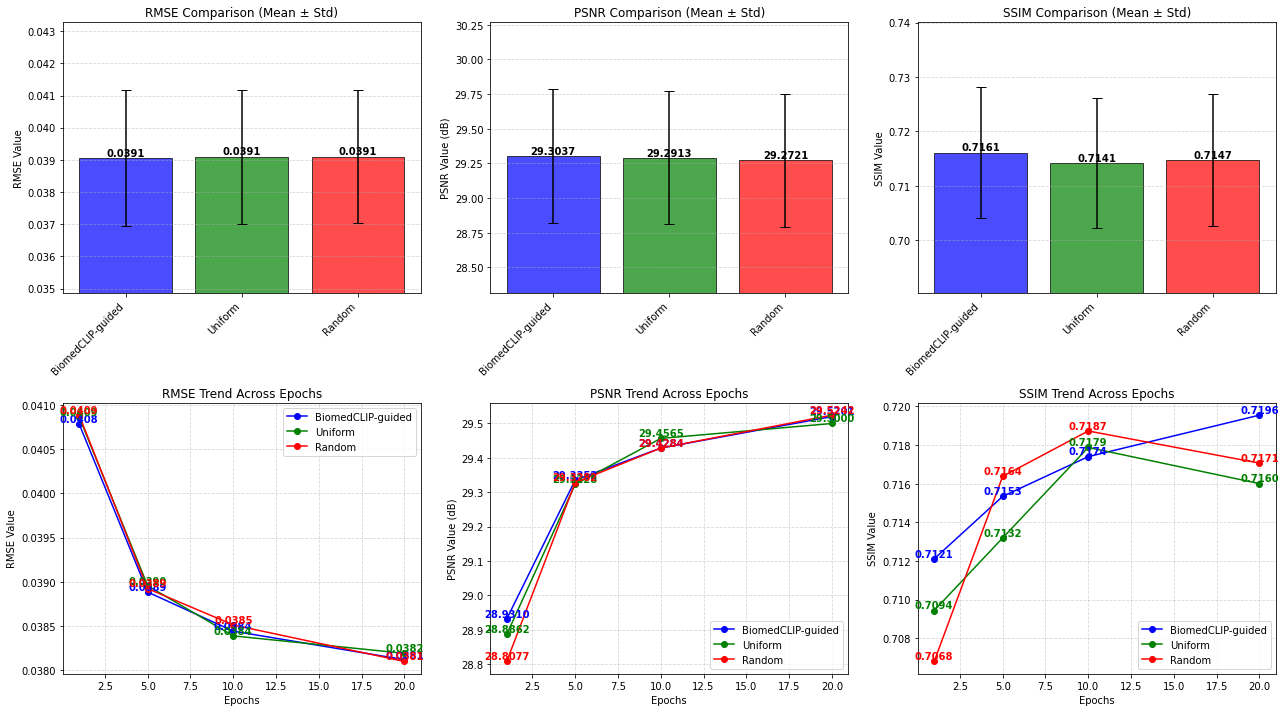

In [47]:
# 모델 리스트 및 색상 설정
model_names = ["moanet", "moanet_weight/uniform", "moanet_weight/random"]
colors = ["b", "g", "r"]  # 각 모델별 색상 지정

# x축 레이블 변경 매핑
label_mapping = {
    "moanet": "BiomedCLIP-guided",
    "moanet_weight/uniform": "Uniform",
    "moanet_weight/random": "Random"
}

# 평가할 epoch 리스트
epochs_list = [1, 5, 10, 20, 30]  # 모든 epoch에 대해 그래프를 그릴 예정

# CSV 파일 경로 설정 (각 모델의 epoch별 파일 불러오기)
csv_paths = {
    model: {epoch: f"{root}/{model}/results_{epoch}.csv" for epoch in epochs_list}
    for model in model_names
}

# 각 파일을 읽어와서 데이터프레임 저장
df_dict = {}
for model, epoch_files in csv_paths.items():
    df_dict[model] = {}
    for epoch, path in epoch_files.items():
        if os.path.exists(path):  # 파일이 존재할 경우만 읽기
            df_dict[model][epoch] = pd.read_csv(path)

# 평균 및 표준편차 그래프 그리는 함수
def plot_mean_std(ax, metric_name, ylabel):
    x_labels = [label_mapping[model] for model in model_names]  # X축에 변경된 모델 이름 표시
    means = []
    stds = []

    for model in model_names:
        all_values = []
        for epoch in epochs_list:
            if epoch in df_dict[model]:
                all_values.extend(df_dict[model][epoch][metric_name].values)  # 모든 epoch의 값 합치기

        if all_values:
            means.append(np.mean(all_values))
            stds.append(np.std(all_values))
        else:
            means.append(0)
            stds.append(0)

    means = np.array(means)
    stds = np.array(stds)

    # y축 범위 설정 (최소/최대값 + 표준편차의 3배)
    ymin = np.min(means - stds)
    ymax = np.max(means + stds)
    ax.set_ylim(ymin, ymax)

    # 막대그래프 (오차 막대 포함)
    bars = ax.bar(x_labels, means, yerr=stds / 2, capsize=5, color=colors, alpha=0.7, edgecolor="black")

    # 막대 위에 평균값 표시
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{mean:.4f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric_name} Comparison (Mean ± Std)")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

# Epoch 별 변화 그래프
def plot_epoch_trend(ax, metric_name, ylabel):
    for model, color in zip(model_names, colors):
        means = []
        epochs_available = []
        
        for epoch in epochs_list:
            if epoch in df_dict[model]:
                mean_value = df_dict[model][epoch][metric_name].mean()
                means.append(mean_value)
                epochs_available.append(epoch)

        if means:
            ax.plot(epochs_available, means, marker='o', linestyle='-', color=color, label=label_mapping[model])

            # 각 데이터 포인트 위에 값 표시
            for epoch, mean_value in zip(epochs_available, means):
                ax.text(epoch, mean_value, f"{mean_value:.4f}", ha='center', va='bottom', fontsize=10, fontweight='bold', color=color)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric_name} Trend Across Epochs")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

# 그래프 그리기
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# RMSE 평균 + 표준편차
plot_mean_std(axes[0, 0], "RMSE", "RMSE Value")

# PSNR 평균 + 표준편차
plot_mean_std(axes[0, 1], "PSNR", "PSNR Value (dB)")

# SSIM 평균 + 표준편차
plot_mean_std(axes[0, 2], "SSIM", "SSIM Value")

# RMSE epoch 변화
plot_epoch_trend(axes[1, 0], "RMSE", "RMSE Value")

# PSNR epoch 변화
plot_epoch_trend(axes[1, 1], "PSNR", "PSNR Value (dB)")

# SSIM epoch 변화
plot_epoch_trend(axes[1, 2], "SSIM", "SSIM Value")

# 이미지 저장
plt.tight_layout()
plt.savefig(f"{root}/cmp_epoch_weight_type.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2031833/1676321496.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")
/tmp/ipykernel_2031833/1676321496.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")
/tmp/ipykernel_2031833/1676321496.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")


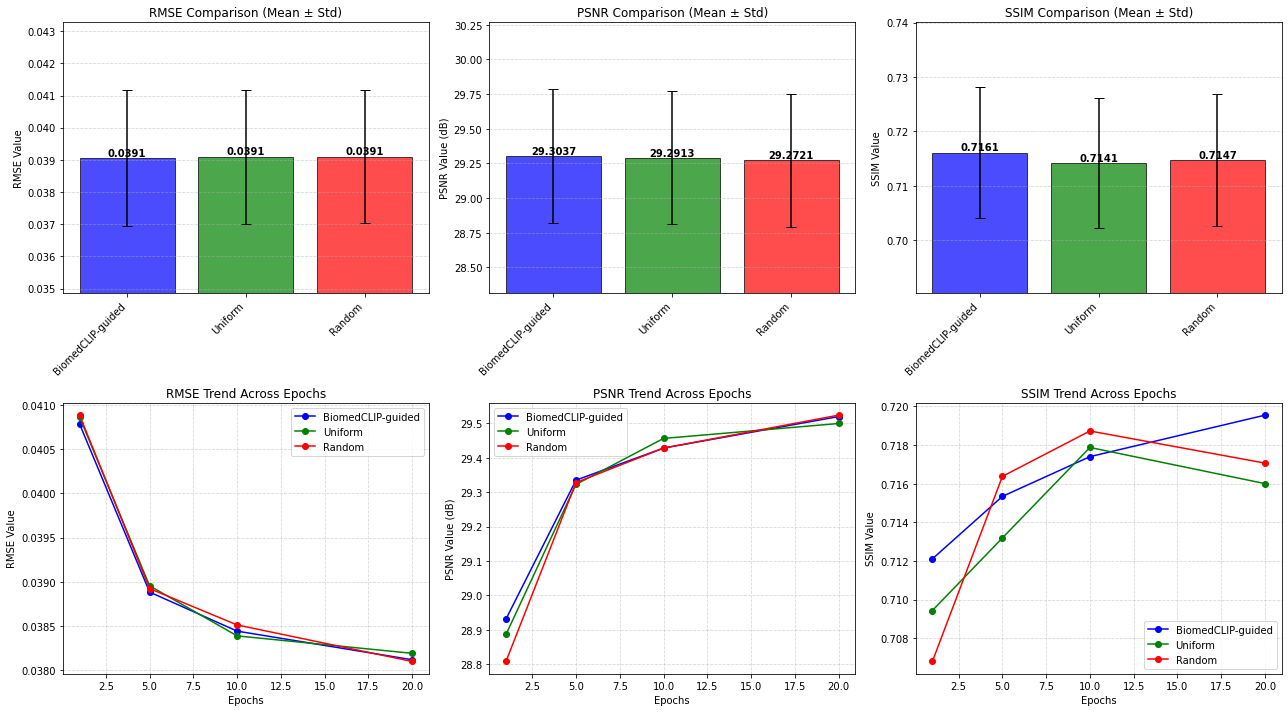

In [55]:
# 모델 리스트 및 색상 설정
model_names = ["moanet", "moanet_weight/uniform", "moanet_weight/random"]
colors = ["b", "g", "r"]  # 각 모델별 색상 지정

# x축 레이블 변경 매핑
label_mapping = {
    "moanet": "BiomedCLIP-guided",
    "moanet_weight/uniform": "Uniform",
    "moanet_weight/random": "Random"
}

# 평가할 epoch 리스트
epochs_list = [1, 5, 10, 20, 30]  # 모든 epoch에 대해 그래프를 그릴 예정

# CSV 파일 경로 설정 (각 모델의 epoch별 파일 불러오기)
csv_paths = {
    model: {epoch: f"{root}/{model}/results_{epoch}.csv" for epoch in epochs_list}
    for model in model_names
}

# 각 파일을 읽어와서 데이터프레임 저장
df_dict = {}
for model, epoch_files in csv_paths.items():
    df_dict[model] = {}
    for epoch, path in epoch_files.items():
        if os.path.exists(path):  # 파일이 존재할 경우만 읽기
            df_dict[model][epoch] = pd.read_csv(path)

# 평균 및 표준편차 그래프 그리는 함수
def plot_mean_std(ax, metric_name, ylabel):
    x_labels = [label_mapping[model] for model in model_names]  # X축에 변경된 모델 이름 표시
    means = []
    stds = []

    for model in model_names:
        all_values = []
        for epoch in epochs_list:
            if epoch in df_dict[model]:
                all_values.extend(df_dict[model][epoch][metric_name].values)  # 모든 epoch의 값 합치기

        if all_values:
            means.append(np.mean(all_values))
            stds.append(np.std(all_values))
        else:
            means.append(0)
            stds.append(0)

    means = np.array(means)
    stds = np.array(stds)

    # y축 범위 설정 (최소/최대값 + 표준편차의 3배)
    ymin = np.min(means - stds)
    ymax = np.max(means + stds)
    ax.set_ylim(ymin, ymax)

    # 막대그래프 (오차 막대 포함)
    bars = ax.bar(x_labels, means, yerr=stds / 2, capsize=5, color=colors, alpha=0.7, edgecolor="black")

    # 막대 위에 평균값 표시
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{mean:.4f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric_name} Comparison (Mean ± Std)")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

def plot_epoch_trend(ax, metric_name, ylabel):
    for model, color in zip(model_names, colors):
        means = []
        epochs_available = []
        
        for epoch in epochs_list:
            if epoch in df_dict[model]:
                mean_value = df_dict[model][epoch][metric_name].mean()
                means.append(mean_value)
                epochs_available.append(epoch)

        if means:
            ax.plot(epochs_available, means, marker='o', linestyle='-', color=color, label=label_mapping[model])

    ax.set_xlabel("Epochs")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric_name} Trend Across Epochs")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)


# 그래프 그리기
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# RMSE 평균 + 표준편차
plot_mean_std(axes[0, 0], "RMSE", "RMSE Value")

# PSNR 평균 + 표준편차
plot_mean_std(axes[0, 1], "PSNR", "PSNR Value (dB)")

# SSIM 평균 + 표준편차
plot_mean_std(axes[0, 2], "SSIM", "SSIM Value")

# RMSE epoch 변화
plot_epoch_trend(axes[1, 0], "RMSE", "RMSE Value")

# PSNR epoch 변화
plot_epoch_trend(axes[1, 1], "PSNR", "PSNR Value (dB)")

# SSIM epoch 변화
plot_epoch_trend(axes[1, 2], "SSIM", "SSIM Value")

# 이미지 저장
plt.tight_layout()
plt.savefig(f"{root}/cmp_epoch_weight_type.png", dpi=300, bbox_inches='tight')
plt.show()